In [0]:
#@title MIT License
#
# Copyright (c) 2019 Andreas Eberlein
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Train a deep neural networks for semantic segmentation based on Virtual KITTI dataset

In [ ]:
# Make sure the correct versions of tensorflow and h5py are installed:
!pip install tensorflow-gpu==1.14.0
!pip install h5py==2.9.0

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.activations as activations
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
import tensorflow.keras.utils as utils
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.optimizers as optimizers


import cv2
import pickle
import h5py

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [4]:
# Run this cell if the notebook is executed on Google Colaboratory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import data_helper
import prepare_data

## Download and preprocess virtual KITTI data set

In [ ]:
# Run this cell if data needs to be downloaded from server
!mkdir -p Data
!wget http://download.europe.naverlabs.com/virtual-kitti-1.3.1/vkitti_1.3.1_rgb.tar
!wget http://download.europe.naverlabs.com/virtual-kitti-1.3.1/vkitti_1.3.1_scenegt.tar
!tar -xvf vkitti_1.3.1_rgb.tar -C Data
!tar -xvf vkitti_1.3.1_scenegt.tar -C Data
!mkdir -p Data_compressed/Preprocessed

In [ ]:
# Run this cell if the reduced data set (with images from 0001/sunset is already
# available and archived in Data.tar.gz)
!mkdir -p Data
!tar -xzvf Data.tar.gz
# !tar -xzvf drive/My\ Drive/Data.tar.gz
!mkdir -p Data_compressed/Preprocessed

Preprocess data and reformat it in `hdf5` format

In [0]:
image_rescale_factor = 3
input_folder_name = 'Data'
output_folder_name = 'Data_compressed'

In [8]:
prepare_data.prepare_data_func(input_folder_name, output_folder_name, image_rescale_factor)

Number of training images for now:  447
Number of training label images for now:  447
{'GuardRail': 0, 'Building': 1, 'Car': 2, 'Pole': 3, 'Van': 4, 'TrafficLight': 5, 'Road': 6, 'Vegetation': 7, 'Misc': 8, 'Tree': 9, 'Terrain': 10, 'TrafficSign': 11, 'Truck': 12, 'Sky': 13}
(447, 125, 414, 3)


In [0]:
processed_training_data_file_name = os.path.join(output_folder_name, 'Preprocessed/ProcessedTrainingData.hdf5')

data_file = h5py.File(processed_training_data_file_name, 'r')

one_hot_encoded_labels = data_file['one_hot_encoded_labels']
train_images = data_file['training_images']

In [10]:
# Briefly check whether reimport of data worked out
print(one_hot_encoded_labels.shape)
print(train_images.shape)

(447, 125, 414, 14)
(447, 125, 414, 3)


In [11]:
dict_file_name = os.path.join(output_folder_name, 'Preprocessed/Dictionaries.dat')
dict_file = open(dict_file_name, 'rb')
value_category_id_mappings = pickle.load(dict_file)
dict_file.close()
values_categories_dict, categories_ids_dict, ids_categories_dict, \
            ids_values_dict, values_ids_dict = value_category_id_mappings
print(categories_ids_dict)
print(ids_values_dict)

{'GuardRail': 0, 'Building': 1, 'Car': 2, 'Pole': 3, 'Van': 4, 'TrafficLight': 5, 'Road': 6, 'Vegetation': 7, 'Misc': 8, 'Tree': 9, 'Terrain': 10, 'TrafficSign': 11, 'Truck': 12, 'Sky': 13}
{0: (255, 100, 255), 1: (140, 140, 140), 2: (200, 200, 200), 3: (255, 130, 0), 4: (230, 208, 202), 5: (200, 200, 0), 6: (100, 60, 100), 7: (90, 240, 0), 8: (80, 80, 80), 9: (0, 199, 0), 10: (210, 0, 200), 11: (255, 255, 0), 12: (160, 60, 60), 13: (90, 200, 255)}


In [0]:
# Now we reconstruct a few label images from one-hot encoding to colour coding for testing purposes
decoded_labels = data_helper.oneHotDecodeImages(one_hot_encoded_labels[0:4], ids_values_dict)

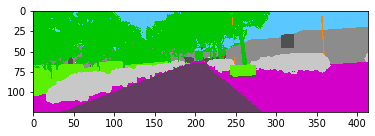

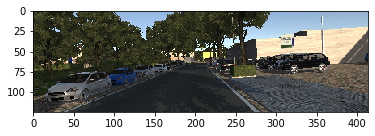

In [13]:
data_helper.plot_as_rgb_image(decoded_labels[0])
plt.show()
data_helper.plot_as_rgb_image(train_images[0], input_normalized=True)
plt.show()

## Setting model and training parameters

In [14]:
batch_size = 16
epochs = 250
img_shape = train_images[0].shape
img_shape

(125, 414, 3)

## Define and train simple model
In the following, a simple model is trained with an architecture inspired by U-net and Fast-SCNN (1902.04502).

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


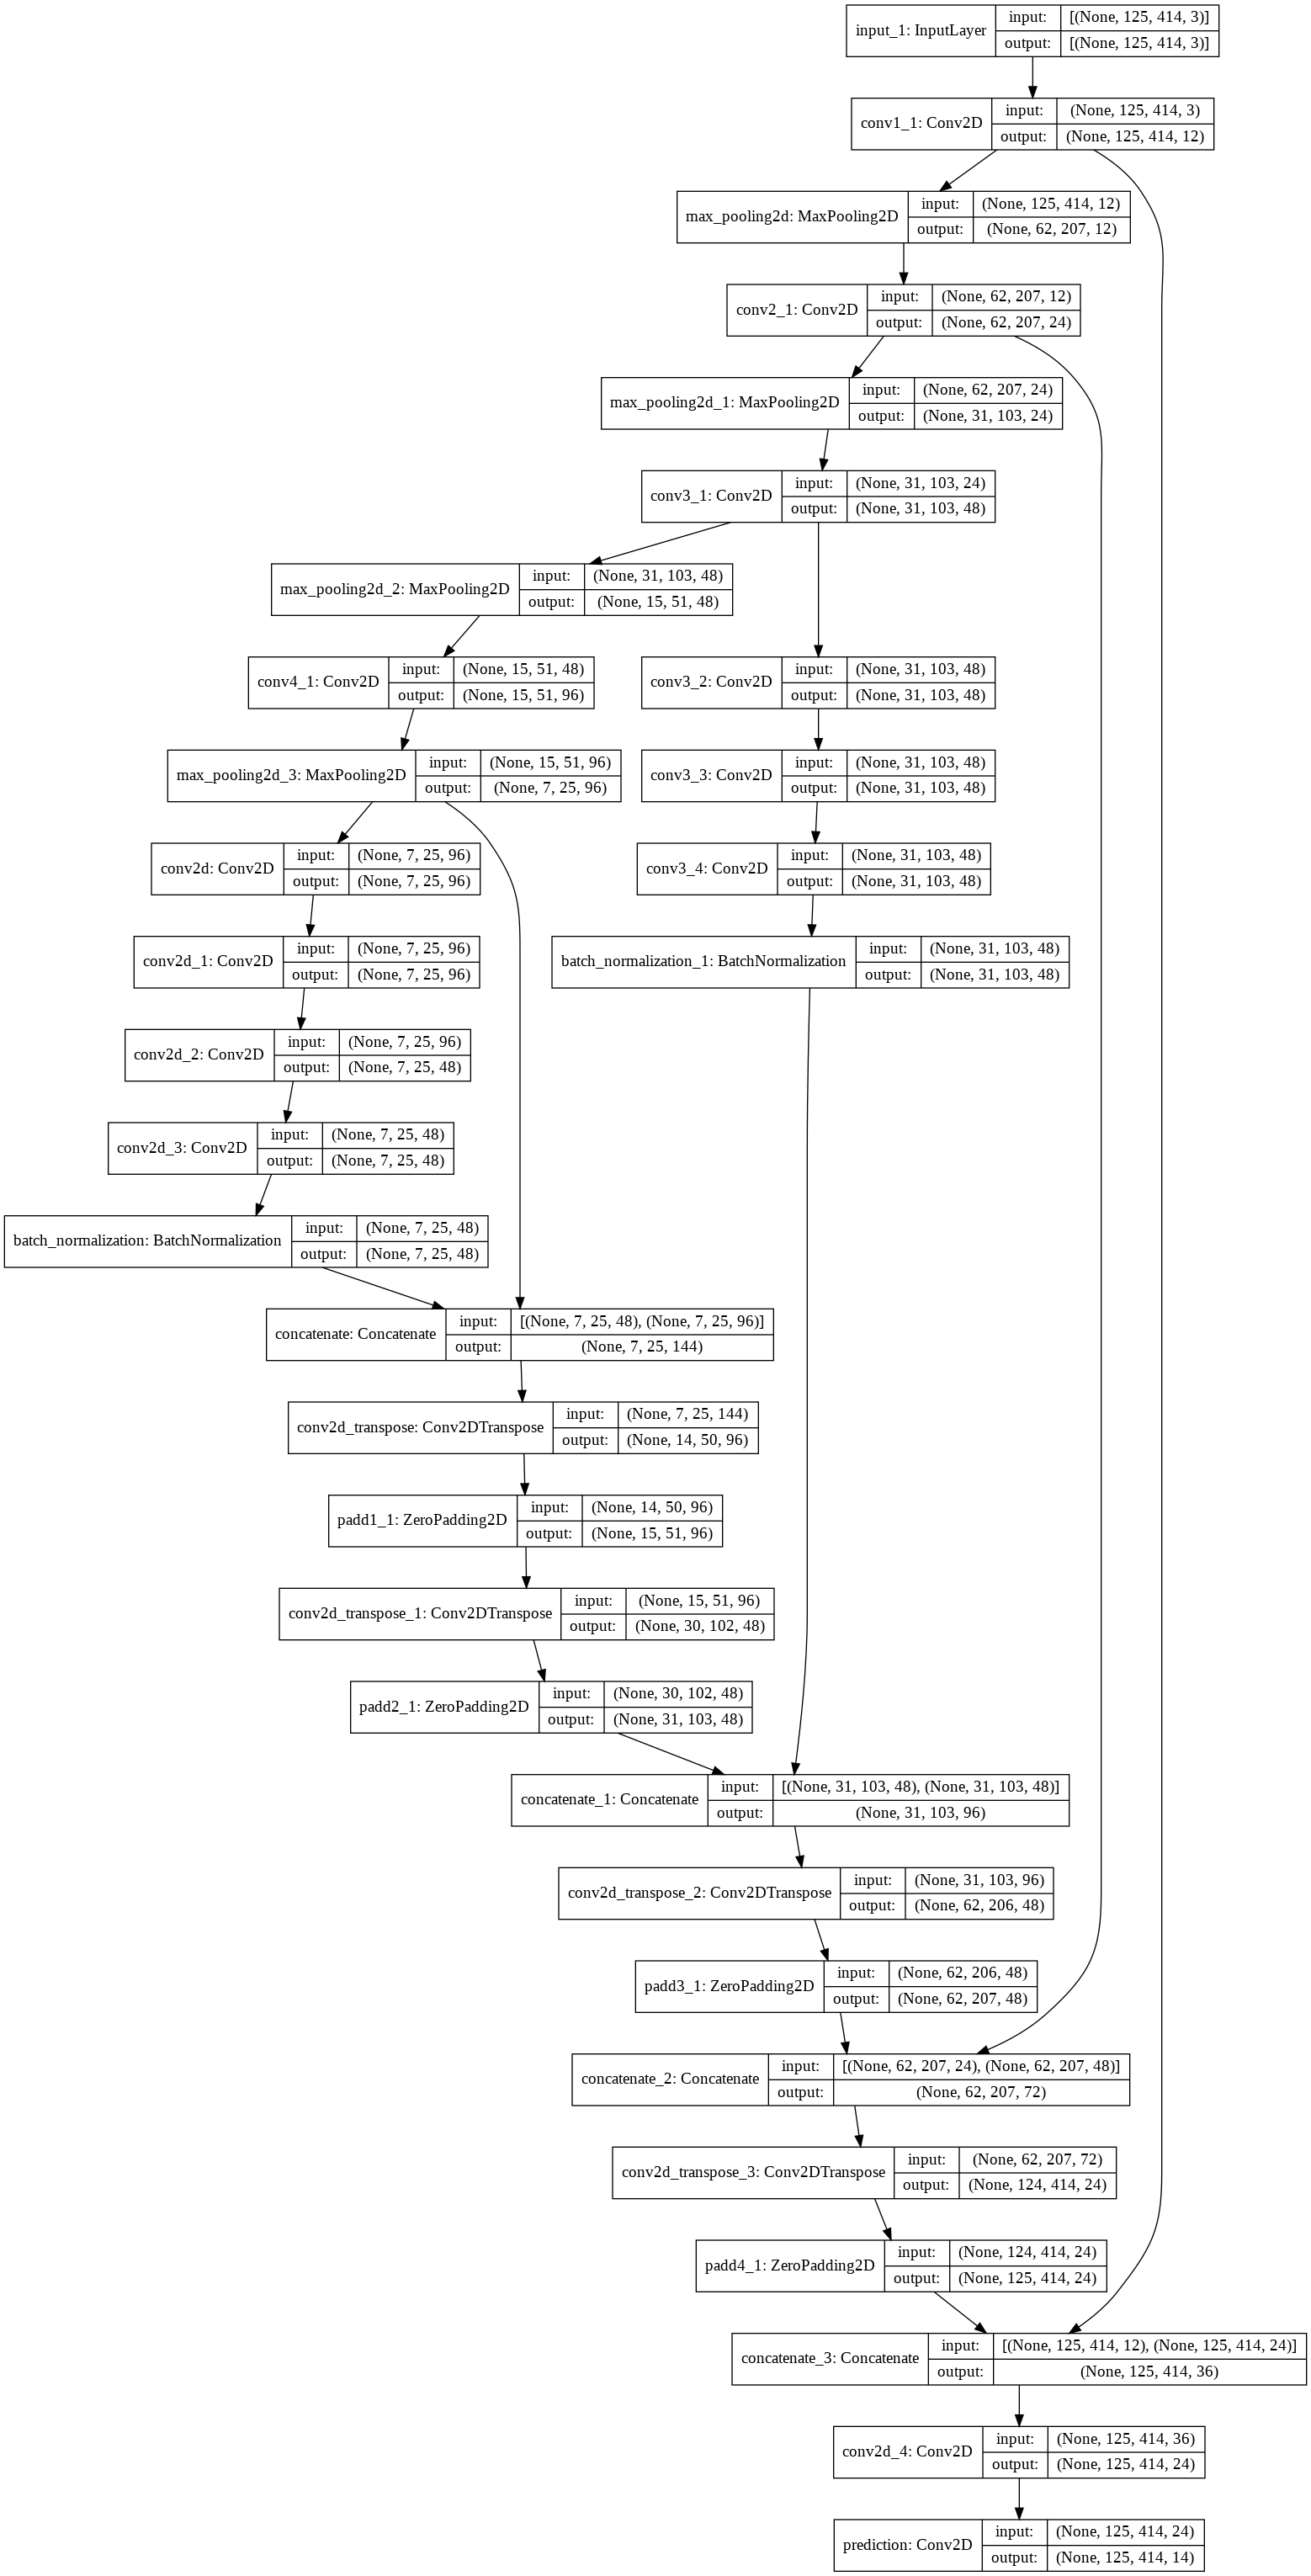

In [15]:
def multiBranchWithSkipLayers():
    # Architecture inspired by U-net and Fast-SCNN (1902.04502)
    inputs = layers.Input(shape=img_shape)
    # Encoder part
    conv1_1 = layers.Conv2D(12, 3, padding='same', activation='relu', name='conv1_1')(inputs)
    pool1_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1_1)
    conv2_1 = layers.Conv2D(24, 3, padding='same', activation='relu', name='conv2_1')(pool1_1)
    pool2_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_1')(pool2_1)
    pool3_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv3_1)
    conv4_1 = layers.Conv2D(96, 3, padding='same', activation='relu', name='conv4_1')(pool3_1)
    pool4_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv4_1)
    
    # Bottleneck layers for deep part
    conv5_1 = layers.Conv2D(96, 1, padding='same', activation='relu')(pool4_1)
    conv6_1 = layers.Conv2D(96, 3, padding='same', activation='relu')(conv5_1)
    conv7_1 = layers.Conv2D(48, 3, padding='same', activation='relu')(conv6_1)
    conv8_1 = layers.Conv2D(48, 1, padding='same', activation='relu')(conv7_1)
    bottleneck_output = layers.BatchNormalization()(conv8_1)
    
    # Convolutional layers for "intermediate part"
    conv3_2 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_2')(conv3_1)
    conv3_3 = layers.Conv2D(48, 1, padding='same', activation='relu', name='conv3_3')(conv3_2)
    conv3_4 = layers.Conv2D(48, 3, padding='same', activation='relu', name='conv3_4')(conv3_3)
    conv3_4_norm = layers.BatchNormalization()(conv3_4)
    
    # Decoder part
    concat0_1 = layers.Concatenate()([bottleneck_output, pool4_1])
    deconv1_1 = layers.Conv2DTranspose(96, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat0_1)
    padd1_1 = layers.ZeroPadding2D(padding=((0,1), (0,1)), name='padd1_1')(deconv1_1)
    deconv2_1 = layers.Conv2DTranspose(48, 3, strides=(2,2), padding='same',
                                       activation='relu')(padd1_1)
    padd2_1 = layers.ZeroPadding2D(padding=((0,1), (0,1)), name='padd2_1')(deconv2_1)
    concat1_1 = layers.Concatenate()([conv3_4_norm, padd2_1])
    deconv3_1 = layers.Conv2DTranspose(48, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat1_1)
    padd3_1 = layers.ZeroPadding2D(padding=((0,0), (0,1)), name='padd3_1')(deconv3_1)
    concat2_1 = layers.Concatenate()([conv2_1, padd3_1])
    deconv4_1 = layers.Conv2DTranspose(24, 3, strides=(2,2), padding='same',
                                       activation='relu')(concat2_1)
    padd4_1 = layers.ZeroPadding2D(padding=((0,1), (0,0)), name='padd4_1')(deconv4_1)
    concat3_1 = layers.Concatenate()([conv1_1, padd4_1])
    deconv5_1 = layers.Conv2D(24, 3, padding='same', activation='relu')(concat3_1)
    
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 3, padding='same', 
                                activation=activations.softmax, name='prediction')(deconv5_1)
    
    # Ideas for optimization:
    # - Introduce DepthwiseConv2d instead of Conv2d on encoder path
    # - Use upsampling for very heavy Conv2DTranspose layers
    # - Conveniently cut images so that zero padding is unnecessary
    # - Introduce batch normalization on every branch that is merged via concatenation
    # - Use more images during training!
    
    return models.Model(inputs=inputs, outputs=predictions)

simple_model = multiBranchWithSkipLayers()
utils.plot_model(simple_model, to_file='simple_model.png', show_shapes=True)

In [16]:
optimizer = optimizers.RMSprop()

simple_model.compile(optimizer=optimizer,
                     loss=losses.CategoricalCrossentropy(),
                     metrics=['accuracy', metrics.MeanIoU(num_classes=one_hot_encoded_labels.shape[3])]
                    )
simple_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 125, 414, 3) 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 125, 414, 12) 336         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 207, 12)  0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 62, 207, 24)  2616        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [17]:
def learning_rate_schedule(epoch):
    return 0.001 / 3**(epoch // 75)

lr_schedule = callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)

history_simple = simple_model.fit(train_images[0:], one_hot_encoded_labels[0:],
                                  epochs=epochs, batch_size=batch_size,
                                  validation_split=0.15, verbose=1,
                                  initial_epoch=0, callbacks=[lr_schedule],
                                  shuffle='batch')

Train on 379 samples, validate on 68 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/250
379/379 [==============================] - 15s 41ms/sample - loss: 1.5036 - acc: 0.5271 - mean_io_u: 0.4643 - val_loss: 1.7952 - val_acc: 0.3670 - val_mean_io_u: 0.4643

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/250
379/379 [==============================] - 9s 24ms/sample - loss: 0.9601 - acc: 0.6895 - mean_io_u: 0.4643 - val_loss: 1.4944 - val_acc: 0.4237 - val_mean_io_u: 0.4643

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/250
379/379 [==============================] - 9s 25ms/sample - loss: 0.8286 - acc: 0.7389 - mean_io_u: 0.4643 - val_loss: 1.6413 - val_acc: 0.4667 - val_mean_io_u: 0.4643

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/250
379/379 [=======================

In [18]:
import pandas as pd
hist_simple = pd.DataFrame(history_simple.history)
hist_simple

,loss,acc,mean_io_u,val_loss,val_acc,val_mean_io_u,lr
0,1.503574,0.527106,0.464286,1.795171,0.367010,0.464286,0.001000
1,0.960146,0.689493,0.464286,1.494412,0.423652,0.464286,0.001000
2,0.828580,0.738885,0.464286,1.641329,0.466688,0.464286,0.001000
3,0.724386,0.771026,0.464286,1.336986,0.563315,0.464286,0.001000
4,0.678778,0.786946,0.464286,1.380683,0.513568,0.464286,0.001000
...,...,...,...,...,...,...,...
245,0.030270,0.989492,0.667458,0.090474,0.976003,0.668793,0.000037
246,0.030231,0.989521,0.667800,0.090344,0.976026,0.667392,0.000037
247,0.030200,0.989520,0.668295,0.090410,0.976029,0.668540,0.000037
248,0.030148,0.989545,0.668348,0.090719,0.976031,0.669190,0.000037


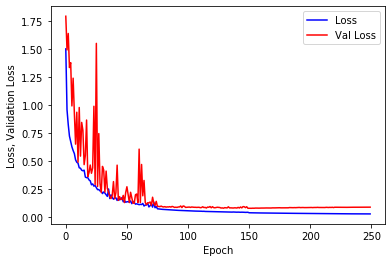

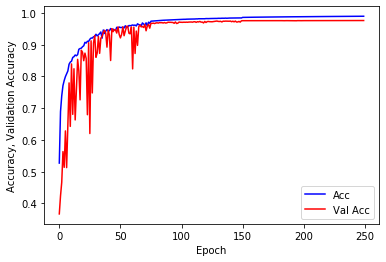

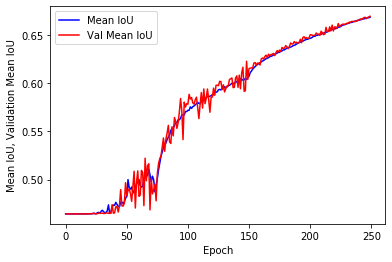

In [19]:
start = 0
end = epochs
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss, Validation Loss')
plt.plot(hist_simple['loss'][start:end], 'b-', label='Loss')
plt.plot(hist_simple['val_loss'][start:end], 'r-', label='Val Loss')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy, Validation Accuracy')
plt.plot(hist_simple['acc'][start:end], 'b-', label='Acc')
plt.plot(hist_simple['val_acc'][start:end], 'r-', label='Val Acc')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean IoU, Validation Mean IoU')
plt.plot(hist_simple['mean_io_u'][start:end], 'b-', label='Mean IoU')
plt.plot(hist_simple['val_mean_io_u'][start:end], 'r-', label='Val Mean IoU')
plt.legend()

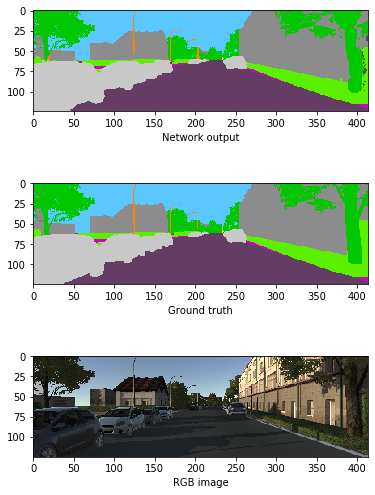

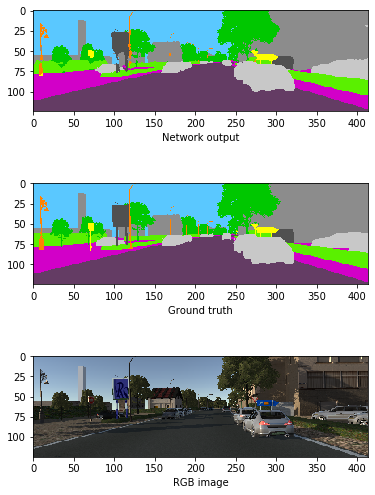

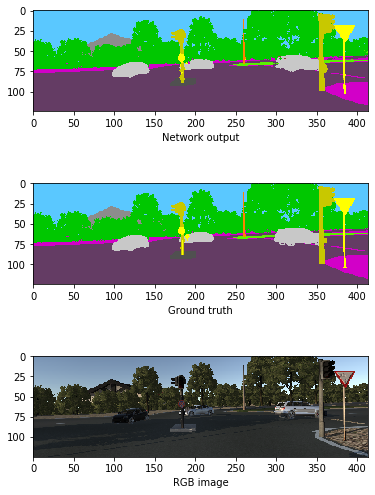

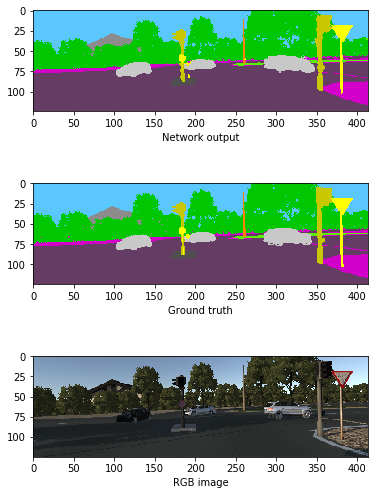

In [21]:
# Plot a few images for visualizing the results:
test_prediction_simple = simple_model.predict(train_images[-4:])
test_prediction_simple_decoded = data_helper.oneHotDecodeImages(test_prediction_simple, ids_values_dict)
ground_truth_decoded = data_helper.oneHotDecodeImages(one_hot_encoded_labels[-4:], ids_values_dict)

for idx in range(-4, 0, 1):
    fig = plt.figure(figsize=(6, 9))
    fig.add_subplot(3, 1, 1)
    data_helper.plot_as_rgb_image(test_prediction_simple_decoded[idx])
    plt.xlabel('Network output')
    fig.add_subplot(3, 1, 2)
    data_helper.plot_as_rgb_image(ground_truth_decoded[idx])
    plt.xlabel('Ground truth')
    fig.add_subplot(3, 1, 3)
    data_helper.plot_as_rgb_image(train_images[idx], input_normalized=True)
    plt.xlabel('RGB image')
    plt.savefig('result_example_simple_model' + str(idx+5) + '.png')
    plt.show()
    print()

## Define and train advanced model

In the following, a more sophisticated model is trained with an architecture inspired by EdgeSegNet (1905.04222). Note that the paper does not contain all information on kernel sizes, so I needed to guess.


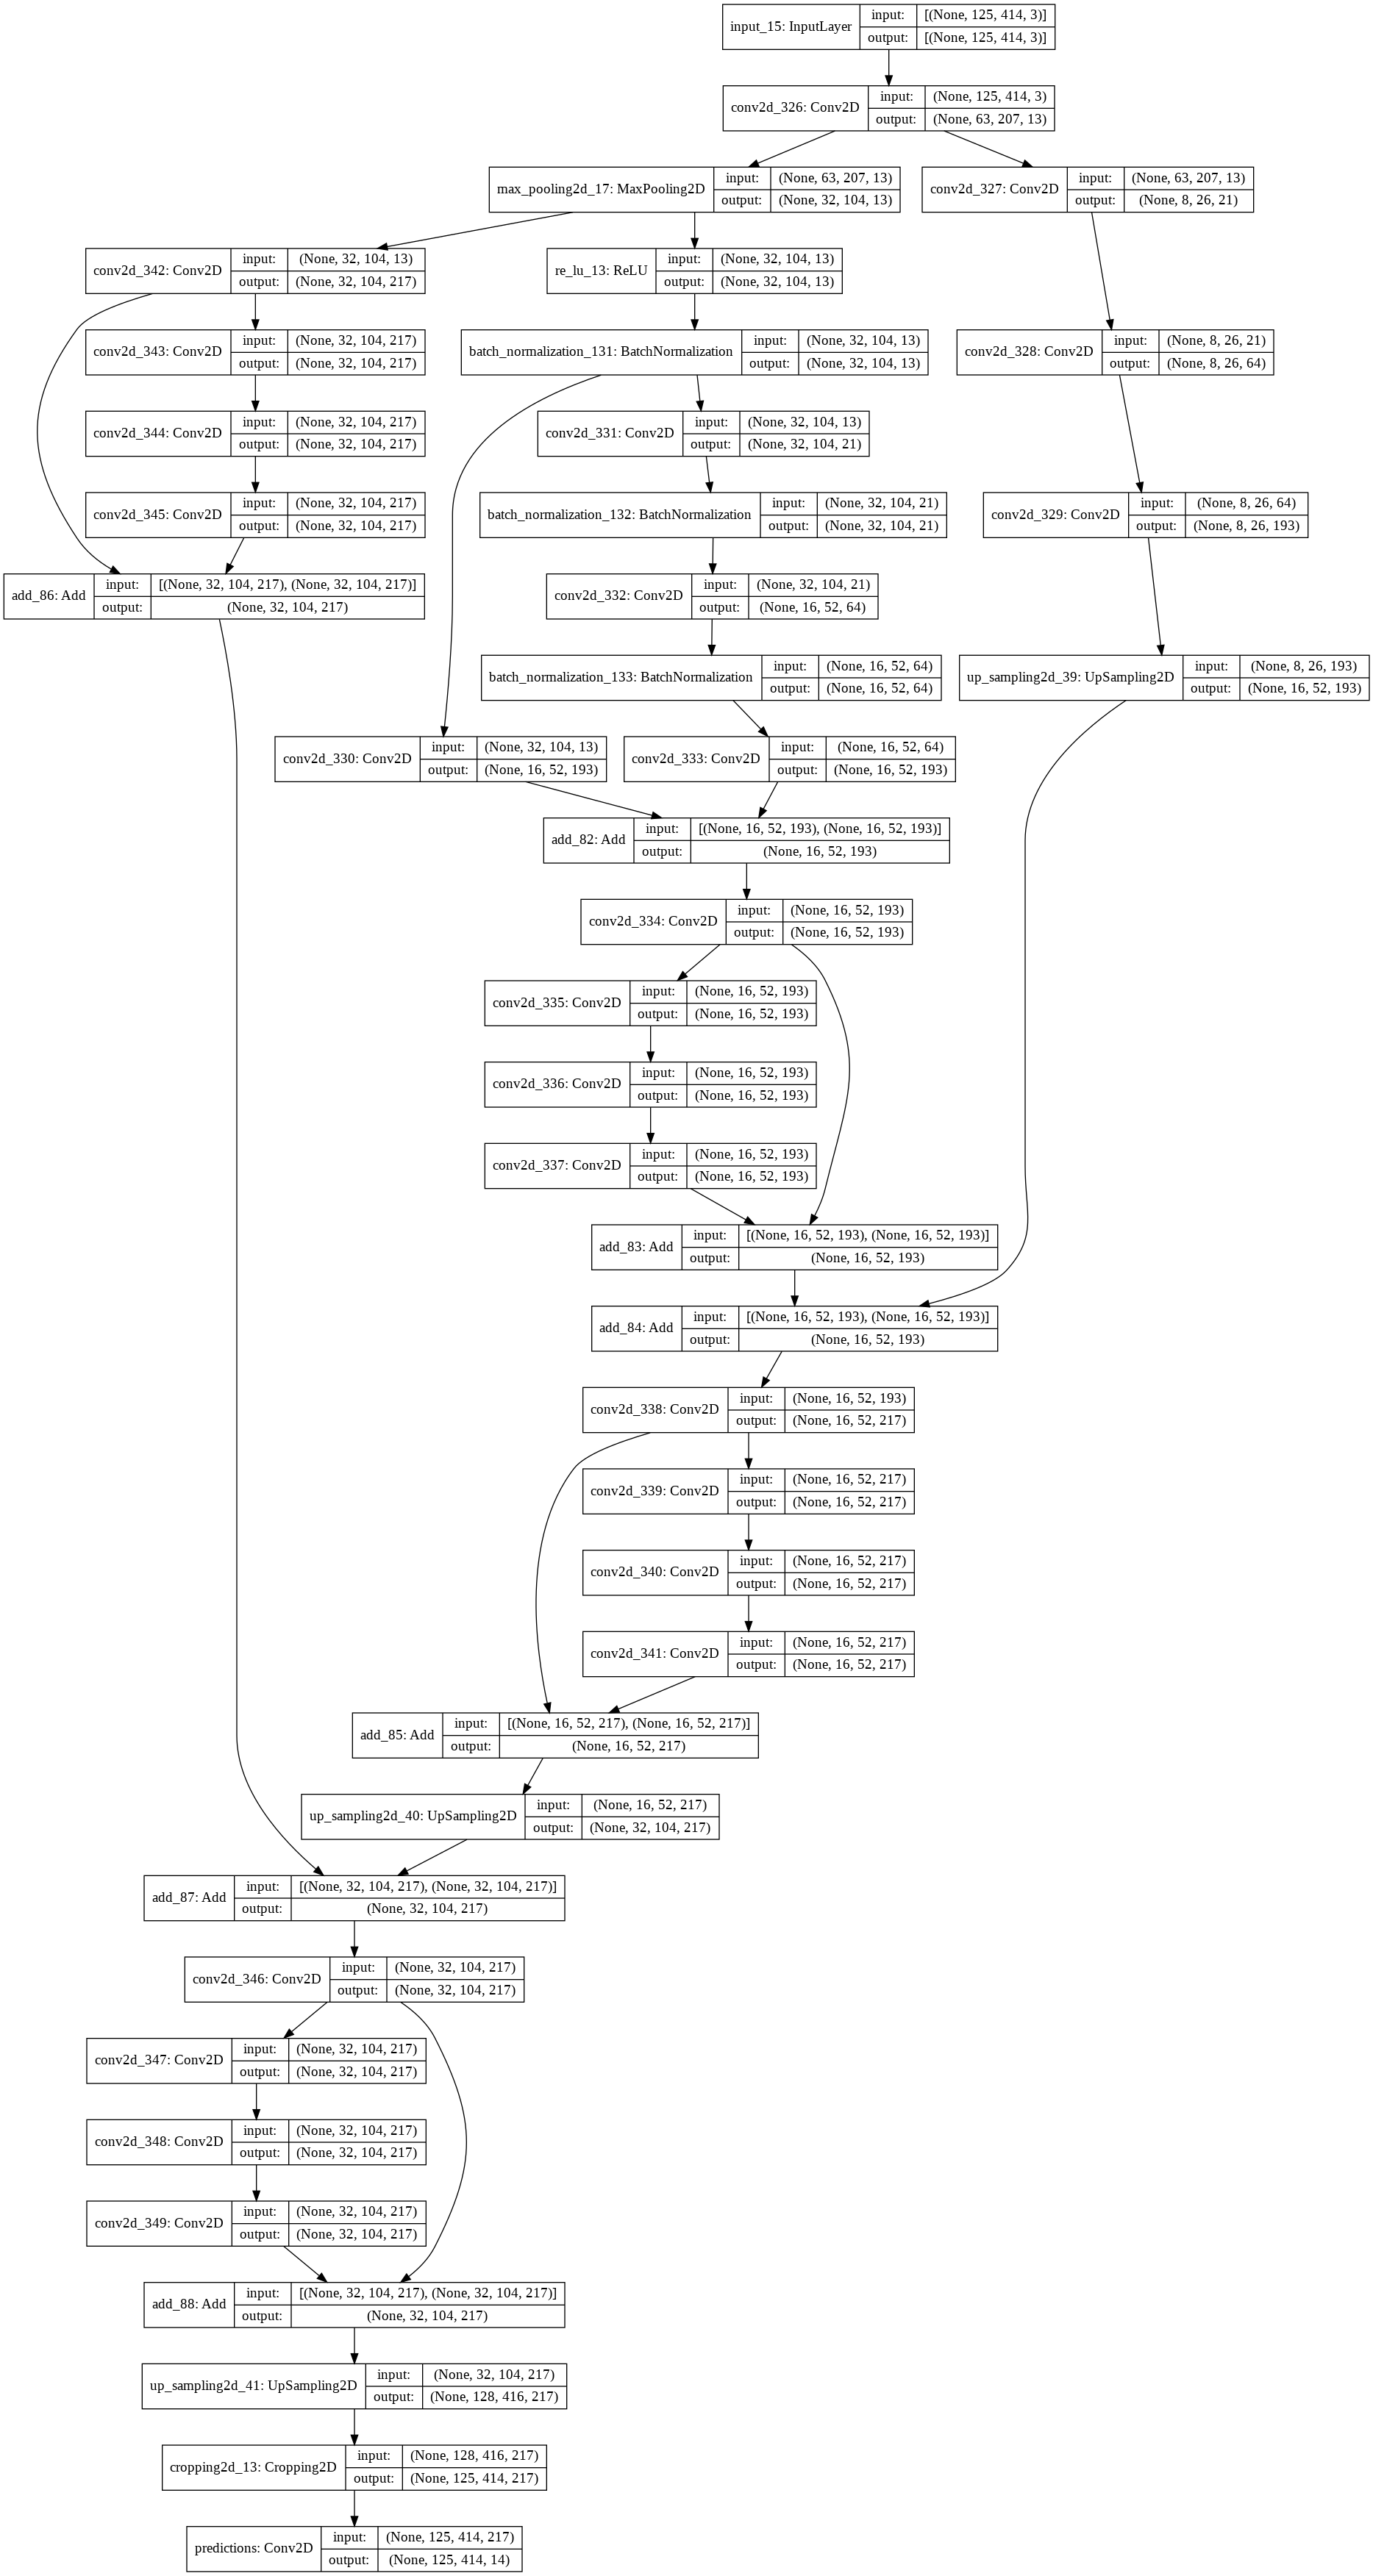

In [69]:
def residual_bottleneck_module(input_tensor, output_kernel_size, inv_scale_factor):
    relu_in = layers.ReLU()(input_tensor)
    bn_in = layers.BatchNormalization()(relu_in)
    
    conv1 = layers.Conv2D(output_kernel_size, 3, strides=inv_scale_factor, padding='same')(bn_in)
    
    conv2_1 = layers.Conv2D(output_kernel_size // 9, 1, padding='same', activation='relu')(bn_in)
    bn2_2 = layers.BatchNormalization()(conv2_1)
    conv2_2 = layers.Conv2D(output_kernel_size // 3, 3, strides=inv_scale_factor, 
                            padding='same', activation='relu')(bn2_2)
    bn2_3 = layers.BatchNormalization()(conv2_2)
    conv2_3 = layers.Conv2D(output_kernel_size, 1, padding='same', activation='relu')(bn2_3)
    
    out = layers.add([conv1, conv2_3])
    
    return out

def bottleneck_reduction_module(input_tensor, output_kernel_size, kernel_growth_per_layer):
    # Note: The kernel sizes are not specified in the paper!
    conv1 = layers.Conv2D(output_kernel_size // kernel_growth_per_layer**2, 3, 
                          strides=8, padding='same', activation='relu')(input_tensor)
    conv2 = layers.Conv2D(output_kernel_size // kernel_growth_per_layer, 
                          1, padding='same', activation='relu')(conv1)
    conv3 = layers.Conv2D(output_kernel_size, 3, padding='same')(conv2)
    return conv3

def refine_module(input_tensor, output_kernel_size, kernel_growth_per_layer):
    conv = layers.Conv2D(output_kernel_size, 1, padding='same')(input_tensor)
    
    conv1_1 = layers.Conv2D(output_kernel_size // kernel_growth_per_layer**2, 
                            1, padding='same', activation='relu')(conv)
    conv1_2 = layers.Conv2D(output_kernel_size // kernel_growth_per_layer, 
                            3, padding='same', activation='relu')(conv1_1)
    conv1_3 = layers.Conv2D(output_kernel_size, 3, padding='same')(conv1_2)
    
    out = layers.Add()([conv, conv1_3])
    
    return out
    
def advanced_model_func():
    # Architecture inspired by EdgeSegNet (1905.04222)
    inputs = layers.Input(shape=img_shape)
    
    conv1 = layers.Conv2D(13, 7, strides=2, padding='same')(inputs)
    
    # Branch 1:
    brm1 = bottleneck_reduction_module(conv1, 193, 3)
    brs1 = layers.UpSampling2D(size=(2,2))(brm1)
    
    # Branch 2:
    pool2 = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(conv1)
    rbm2 = residual_bottleneck_module(pool2, 193, 2)
    rm2 = refine_module(rbm2, 193, 1)
    
    # Merging branches 1 and 2:
    add12 = layers.Add()([brs1, rm2])
    rm12 = refine_module(add12, 217, 1)
    brs12 = layers.UpSampling2D(size=(2,2))(rm12)
    
    # Branch 3:
    rm3 = refine_module(pool2, 217, 1)
    
    # Merging branches 1+2 and 3:
    add123 = layers.Add()([brs12, rm3])
    rm123 = refine_module(add123, 217, 1)
    brs123 = layers.UpSampling2D(size=(4, 4))(rm123)
    
    # Due to weird input image format, the output needs to be cropped by a few pixels:
    brs123_cropped = layers.Cropping2D(cropping=((1, 2), (1, 1)))(brs123)
    
    predictions = layers.Conv2D(one_hot_encoded_labels.shape[3], 1, padding='same', 
                                activation=activations.softmax, name='predictions')(brs123_cropped)
    
    return models.Model(inputs=inputs, outputs=predictions)

advanced_model = advanced_model_func()
utils.plot_model(advanced_model, to_file='advanced_model.png', show_shapes=True)

In [70]:
optimizer_advanced_model = optimizers.Adam()
metrics_advanced_model = ['accuracy', metrics.MeanIoU(num_classes=one_hot_encoded_labels.shape[3])]

advanced_model.compile(optimizer=optimizer_advanced_model,
                       loss=losses.CategoricalCrossentropy(),
                       metrics=metrics_advanced_model
                      )
advanced_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 125, 414, 3) 0                                            
__________________________________________________________________________________________________
conv2d_326 (Conv2D)             (None, 63, 207, 13)  1924        input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 32, 104, 13)  0           conv2d_326[0][0]                 
__________________________________________________________________________________________________
re_lu_13 (ReLU)                 (None, 32, 104, 13)  0           max_pooling2d_17[0][0]           
___________________________________________________________________________________________

In [71]:
def learning_rate_schedule(epoch):
    lr_base = 0.0002
    if epoch < 10:
        return lr_base / 10
    return lr_base / 2**(epoch // 100)

lr_schedule = callbacks.LearningRateScheduler(learning_rate_schedule, verbose=1)
early_stopping_val_loss = callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=25, verbose=1,
                                                  mode='auto')

history_adv_mod = advanced_model.fit(train_images[0:], one_hot_encoded_labels[0:],
                                     epochs=epochs, batch_size=batch_size * 2,
                                     validation_split=0.15, verbose=1, 
                                     initial_epoch=0, 
                                     callbacks=[lr_schedule, early_stopping_val_loss], 
                                     shuffle='batch')

Train on 379 samples, validate on 68 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 1/250
379/379 [==============================] - 26s 69ms/sample - loss: 2.1649 - acc: 0.3564 - mean_io_u_16: 0.4643 - val_loss: 2.2906 - val_acc: 0.3559 - val_mean_io_u_16: 0.4643

Epoch 00002: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 2/250
379/379 [==============================] - 17s 44ms/sample - loss: 1.5128 - acc: 0.5519 - mean_io_u_16: 0.4643 - val_loss: 2.1341 - val_acc: 0.4464 - val_mean_io_u_16: 0.4643

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 3/250
379/379 [==============================] - 17s 44ms/sample - loss: 1.3040 - acc: 0.5966 - mean_io_u_16: 0.4643 - val_loss: 2.0649 - val_acc: 0.5010 - val_mean_io_u_16: 0.4643

Epoch 00004: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 4/250
379/379 [==============================] - 16s 43ms/sample - loss: 1.1832 - acc: 0.6276 - mean_io_u_16: 0.

In [72]:
import pandas as pd
hist_advanced = pd.DataFrame(history_adv_mod.history)
hist_advanced

,loss,acc,mean_io_u_16,val_loss,val_acc,val_mean_io_u_16,lr
0,2.164930,0.356366,0.464286,2.290644,0.355938,0.464286,0.00002
1,1.512834,0.551946,0.464286,2.134076,0.446450,0.464286,0.00002
2,1.303981,0.596578,0.464286,2.064898,0.500993,0.464286,0.00002
3,1.183167,0.627588,0.464286,1.975152,0.515357,0.464286,0.00002
4,1.090339,0.655980,0.464286,1.945760,0.453890,0.464286,0.00002
...,...,...,...,...,...,...,...
233,0.149423,0.935128,0.537307,0.197957,0.921641,0.536745,0.00005
234,0.149385,0.935116,0.537724,0.197727,0.921707,0.533826,0.00005
235,0.149332,0.935157,0.537218,0.197847,0.921460,0.534681,0.00005
236,0.149213,0.935164,0.537599,0.197999,0.921743,0.535708,0.00005


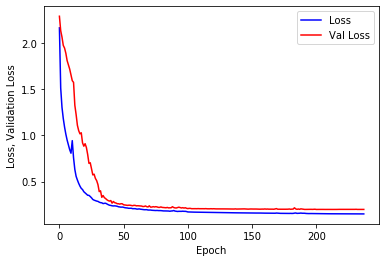

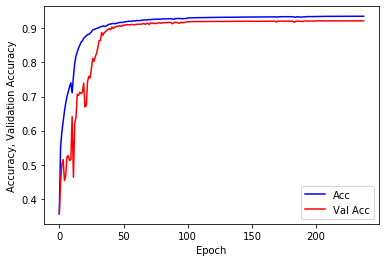

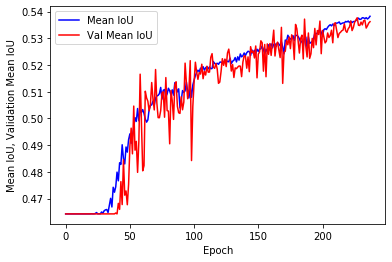

In [73]:
start = 0
end = epochs
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss, Validation Loss')
plt.plot(hist_advanced['loss'][start:end], 'b-', label='Loss')
plt.plot(hist_advanced['val_loss'][start:end], 'r-', label='Val Loss')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Accuracy, Validation Accuracy')
plt.plot(hist_advanced['acc'][start:end], 'b-', label='Acc')
plt.plot(hist_advanced['val_acc'][start:end], 'r-', label='Val Acc')
plt.legend()

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean IoU, Validation Mean IoU')
plt.plot(hist_advanced['mean_io_u_16'][start:end], 'b-', label='Mean IoU')
plt.plot(hist_advanced['val_mean_io_u_16'][start:end], 'r-', label='Val Mean IoU')
plt.legend()

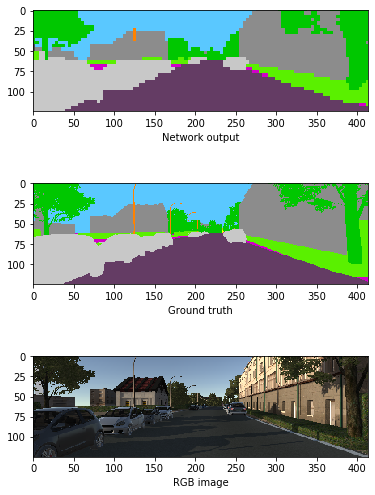

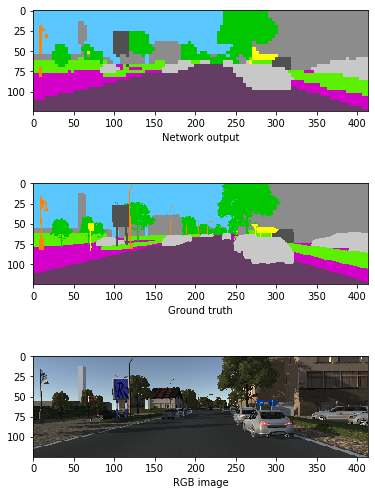

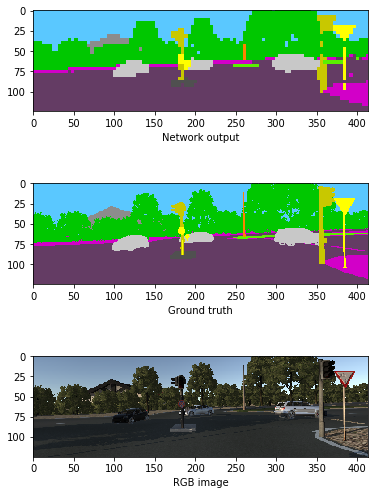

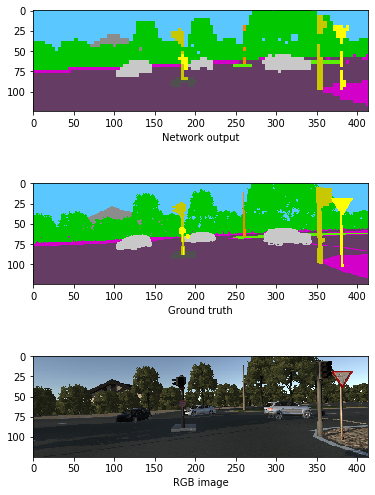

In [75]:
# Plot a few images for visualizing the results:
test_prediction_advanced = advanced_model.predict(train_images[-4:])
test_prediction_advanced_decoded = data_helper.oneHotDecodeImages(test_prediction_advanced, ids_values_dict)
ground_truth_decoded = data_helper.oneHotDecodeImages(one_hot_encoded_labels[-4:], ids_values_dict)

for idx in range(-4, 0, 1):
    fig = plt.figure(figsize=(6, 9))
    fig.add_subplot(3, 1, 1)
    data_helper.plot_as_rgb_image(test_prediction_advanced_decoded[idx])
    plt.xlabel('Network output')
    fig.add_subplot(3, 1, 2)
    data_helper.plot_as_rgb_image(ground_truth_decoded[idx])
    plt.xlabel('Ground truth')
    fig.add_subplot(3, 1, 3)
    data_helper.plot_as_rgb_image(train_images[idx], input_normalized=True)
    plt.xlabel('RGB image')
    plt.savefig('result_example_advanced_model' + str(idx+5) + '.png')
    plt.show()
    print()

These results look quite pixelated, which is not surprising having in mind the low validation mean IoU of 0.54. This results could have several reasons:

- Implementation of network structure different from EdgeSetNet paper due to missing information in the paper
- Result of late upsampling by a factor of four
- Consequence of small number of training images


In [0]:
data_file.close()